In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmcrameri import cm

In [2]:
PROJECTION = ccrs.PlateCarree()


def prep_axes(ax, extents=[-125, -65, 22, 58], grid=False):
    ax.set_extent(extents, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), edgecolor="gray", zorder=2)
    ax.spines[:].set_color("gray")
    if grid:
        gl = ax.gridlines(
            crs=PROJECTION,
            linewidth=0.8,
            color="gray",
            alpha=0.5,
            linestyle="--",
            draw_labels=True,
            zorder=0,
        )
        gl.top_labels = False
        gl.bottom_labels = True
        gl.left_labels = True
        gl.right_labels = False
        gl.xlines = True
        gl.ylines = True
        gl.ylocator = mticker.FixedLocator([30, 40, 50])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return ax


In [3]:
months = {"202107": "2021-07"}

for label, month in months.items():
    # if label == "202107":
    #     method = "cokriging"
    # else:
    method = "cokriging"

    ds = xr.open_dataset(f"../data/intermediate/{method}_results_{label}.nc4").drop_vars("time")
    ds._attrs = {}

    ds_cosif = (
        ds[["predictions", "rmspe"]]
        .rename({"predictions": "cosif_prediction", "rmspe": "cosif_rmspe"})
        .assign_coords(month=pd.to_datetime(month))
        .assign_attrs(units="W/m^2/sr/μm")
    )

ds_cosif

<xarray.Dataset>
Dimensions:           (lat: 720, lon: 1200)
Coordinates:
  * lat               (lat) float64 22.02 22.07 22.12 ... 57.87 57.92 57.97
  * lon               (lon) float64 -125.0 -124.9 -124.9 ... -65.07 -65.02
    month             datetime64[ns] 2021-07-01
Data variables:
    cosif_prediction  (lat, lon) float64 ...
    cosif_rmspe       (lat, lon) float64 ...
Attributes:
    units:    W/m^2/sr/μm

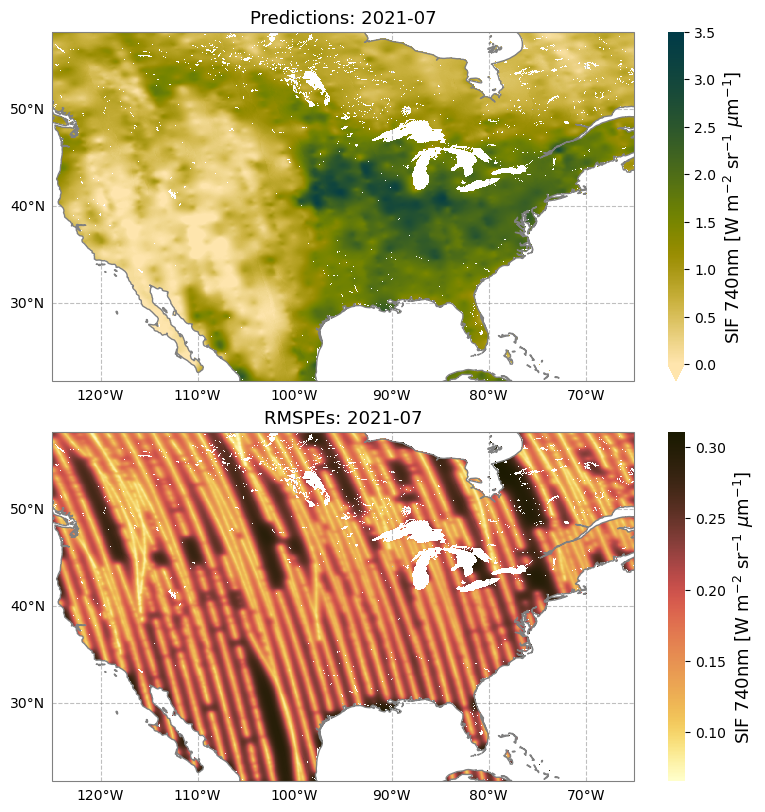

In [4]:
extents = [-125, -65, 22, 58]
SIF_UNITS = "740nm [W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$]"

fig, axes = plt.subplots(
    2, 1, figsize=(8, 8), subplot_kw={"projection": PROJECTION}, constrained_layout=True
)

upper_bound = 3.5

prep_axes(axes[0], extents=extents, grid=True)
field_prediction = xr.plot.imshow(
    darray=ds_cosif.squeeze()["cosif_prediction"],
    zorder=1,
    transform=ccrs.PlateCarree(),
    ax=axes[0],
    cmap=cm.bamako_r,
    vmin=0,
    vmax=upper_bound,
    add_colorbar=False,
    add_labels=False,
)
axes[0].set_title(f"Predictions: {month}", fontsize=13)
cb1 = fig.colorbar(field_prediction, ax=axes[0], extend="min")
cb1.set_label(label=f"SIF {SIF_UNITS}", fontsize=13)
cb1.outline.set_visible(False)

prep_axes(axes[1], extents=extents, grid=True)
field_rmspe = xr.plot.imshow(
    darray=ds_cosif.squeeze()["cosif_rmspe"],
    zorder=1,
    transform=ccrs.PlateCarree(),
    ax=axes[1],
    cmap=cm.lajolla_r,
    add_colorbar=False,
    add_labels=False,
)
axes[1].set_title(f"RMSPEs: {month}", fontsize=13)
cb2 = fig.colorbar(field_rmspe, ax=axes[1])
cb2.set_label(label=f"SIF {SIF_UNITS}", fontsize=13)
cb2.outline.set_visible(False)

fig.savefig(f"../figures/cokriging_{label}.pdf", dpi=300, bbox_inches="tight")

ds_cosif.close()
